# Purchase Data Analysis

## Code

In [1]:
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import plotly.express as px

sns.set()

In [2]:
def plot_avg_and_std_per_segment(df_data: pd.DataFrame, kind='N_Visits'):
    mean_data = df_data.groupby(['SegmentLabel']).mean()[kind]
    std_data = df_data.groupby(['SegmentLabel']).std()[kind]

    fig, ax = plt.subplots(figsize=(12, 6))
    sns.barplot(x=mean_data.index, y=mean_data, yerr=std_data, ax=ax)
    ax.set_ylabel(f'Average {kind}')
    ax.set_xlabel('Segment')
    ax.set_title(f'Average {kind} by Segment');

## Data Loading

The purchase dataset consists of information about the purchases of chocolate candy bars of 500 individuals from a given area when entering a physical FMCG store in a period of 2 years. 

- Data was collected through the loyalty cards customers use at checkout. 
- Data was preprocessed and there are no missing values. 
- The volume of the dataset has been restricted and anonymised to protect the privacy of the customers.
- Each row represents a transaction
- The ID column correspond to the customer ID. Notice that the customers in this dataset are different from the other dataset.

| Variable          | Data type   | Range         | Description                                                                                                        |
|-------------------|-------------|---------------|--------------------------------------------------------------------------------------------------------------------|
| ID                | numerical   | Integer       | Shows a unique   identifier of a customer.                                                                      |
| Day               | numerical   | Integer       | Day when the customer has   visited the store                                                                      |
| Incidence         | categorical | {0,1}         | Indicator whether the  customer has purchased an item from the category of interest                              |
| Brand             | categorical | {0,1,2,3,4,5} | Shows which brand the   customer has purchased. 0=No brand was purchased                                           |
| Quantity          | numerical   | integer       | Number of items bought by   the customer from the product category of interest                                     |
| Last_Inc_Brand    | categorical | {0,1,2,3,4,5} | Shows which brand the   customer has purchased on their previous store visit. 0=No brand was   purchased           |
| Last_Inc_Quantity | numerical   | integer       | Number of items bought by   the customer from the product category of interest during their previous   store visit |
| Price_1           | numerical   | real          | Price of an item from   Brand 1 on a particular day                                                                |
| Price_2           | numerical   | real          | Price of an item from   Brand 2 on a particular day                                                                |
| Price_3           | numerical   | real          | Price of an item from   Brand 3 on a particular day                                                                |
| Price_4           | numerical   | real          | Price of an item from   Brand 4 on a particular day                                                                |
| Price_5           | numerical   | real          | Price of an item from   Brand 5 on a particular day                                                                |
| Promotion_1       | categorical | {0,1}         | Indicator whether Brand 1   was on promotion or not on a particular day                                            |
| Promotion_2       | categorical | {0,1}         | Indicator of whether Brand 2 was on promotion   or not on a particular day                                         |
| Promotion_3       | categorical | {0,1}         | Indicator of whether Brand 3 was on promotion   or not on a particular day                                         |
| Promotion_4       | categorical | {0,1}         | Indicator of whether Brand 4 was on promotion   or not on a particular day                                         |
| Promotion_5       | categorical | {0,1}         | Indicator of whether Brand 5 was on promotion   or not on a particular day                                         |
| Sex             | categorical | {0,1}     | Biological sex (gender)   of a customer. In this dataset there are only 2 different options. 0 = Male,   1=Female                                             |   |
| Marital status  | categorical | {0,1}     | Marital status of a   customer. 0=Single, 1=non-single (divorced / separated / married / widowed)                                                             |   |
| Age             | numerical   | Integer   | The age of the customer   in years, calculated as current year minus the year of birth of the customer   at the time of creation of the dataset               |   |
| Education       | categorical | {0,1,2,3} | Level of education of the   customer. 0=other/unknown, 1=high school, 2=university, 3=graduate   school                                                       |   |
| Income          | numerical   | Real      | Self-reported annual income in US dollars of the customer.                                                                                                    |   |
| Occupation      | categorical | {0,1,2}   | Category of occupation of   the customer. 0=unemployed/unskilled, 1=skilled employee/official,   2=management/self-employed/highly qualified employee/officer |   |
| Settlement size | categorical | {0,1,2}   | The size of the city that the customer lives in. 0=small,   1=mid-sized, 2=big                                                                                |   |

In [3]:
df_purchases = pd.read_csv('data/fmcg-store-purchases.csv')

In [4]:
df_purchases.head()

,ID,Day,Incidence,Brand,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,...,Promotion_3,Promotion_4,Promotion_5,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
0,200000001,1,0,0,0,0,0,1.59,1.87,2.01,...,0,0,0,0,0,47,1,110866,1,0
1,200000001,11,0,0,0,0,0,1.51,1.89,1.99,...,0,0,0,0,0,47,1,110866,1,0
2,200000001,12,0,0,0,0,0,1.51,1.89,1.99,...,0,0,0,0,0,47,1,110866,1,0
3,200000001,16,0,0,0,0,0,1.52,1.89,1.98,...,0,0,0,0,0,47,1,110866,1,0
4,200000001,18,0,0,0,0,0,1.52,1.89,1.99,...,0,0,0,0,0,47,1,110866,1,0


We do not have an equal number of records per customer or an equal number of records per day. So descriptive statistics would neither be appropriate nor useful.

Number of rows in the purchase data?

In [5]:
df_purchases.shape

(58693, 24)

## Segmentation

To segment the new customers in the purchases dataset, we apply the saved models from the segmentation notebook.

Step 1: Standardize the customer columns in the purchase dataset using the saved scaler.

In [6]:
scaler = pickle.load(open('models/segmentation-scaler.pickle', 'rb'))
X_feature_names = pickle.load(open('models/feature-names.pickle', 'rb'))
X = scaler.transform(df_purchases[X_feature_names])

Step 2: Transform the customers from 7 dimensions to 3 dimensions.

In [7]:
pca = pickle.load(open('models/segmentation-pca.pickle', 'rb'))
X_3d = pca.transform(X)

Step 3: Apply k-Means model to segment the data

In [8]:
kmeans_pca = pickle.load(open('models/segmentation-kmeans-pca.pickle', 'rb'))
segments = kmeans_pca.predict(X_3d)

Step 4: Consolidate the segments into the original DataFrame.

In [9]:
df_purchases['Segment'] = segments

# Apply the segment labels
segment_labels = pickle.load(open('models/segment-labels.pickle', 'rb'))
df_purchases['SegmentLabel'] = df_purchases['Segment'].map(segment_labels)

## Descriptive Analysis

First, we want to analyse the purchasing behaviour for customers. 
For that we need to create a new DataFrame where we gather different sets of data.

In [10]:
# Number of visits per customer
df_customer_n_visits = df_purchases[['ID', 'Incidence']].groupby(['ID']).count()
df_customer_n_visits.rename(columns={'Incidence': 'N_Visits'}, inplace=True)
# df_customer_n_visits.head()

In [11]:
# Number of purchases per customer
df_customer_n_purchases = df_purchases[['ID', 'Incidence']].groupby(['ID']).sum()
df_customer_n_purchases.rename(columns={'Incidence': 'N_Purchases'}, inplace=True)
# df_customer_n_purchases.head()

In [12]:
# Create a new DataFrame which hold all the statistics
df_customer_stats = df_customer_n_purchases.join(df_customer_n_visits)

In [13]:
# Compute the purchase frequency per customer.
df_customer_stats['Purchase_Freq'] = df_customer_stats['N_Purchases'] / df_customer_stats['N_Visits']
# df_customer_stats.head()

In [14]:
# Since each customer has a unique SegmentLabel, we can pick the first one.
df_customer_segment = df_purchases[['ID', 'SegmentLabel']].groupby(['ID']).first()

df_customer_stats = df_customer_stats.join(df_customer_segment)
df_customer_stats.head()

,N_Purchases,N_Visits,Purchase_Freq,SegmentLabel
ID,,,,
200000001,9,101,0.089109,fewer-opportunities
200000002,11,87,0.126437,well-off
200000003,10,97,0.103093,fewer-opportunities
200000004,11,85,0.129412,fewer-opportunities
200000005,13,111,0.117117,standard


### Visits per Segment

In [15]:
N_customers = df_customer_stats.shape[0]

df_segment_proportions = df_customer_stats[['N_Visits', 'SegmentLabel']].groupby(['SegmentLabel']).count() / N_customers
df_segment_proportions = df_segment_proportions.rename(columns={'N_Visits': 'Proportion'})
df_segment_proportions.head()

,Proportion
SegmentLabel,
career-focused,0.208
fewer-opportunities,0.376
standard,0.220
well-off,0.196


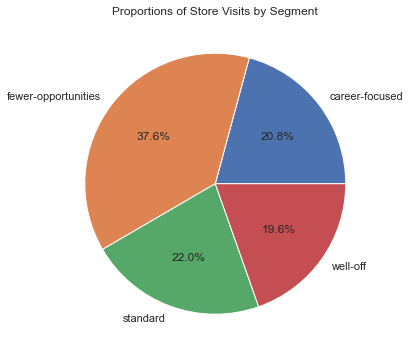

In [16]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.pie(
    x=df_segment_proportions['Proportion'], 
    labels=df_segment_proportions.index.values,
    autopct='%1.1f%%'
)
ax.set_title('Proportions of Store Visits by Segment');

The pie charts gives us an idea of how store visitors are distributed across segments.

### Purchase Occasion

Next, we want to find a quantitative measure to describe the purchase behaviours by segments.
In order words, we would like to answer two questions:

1. How often do people from different segment visit the store?
2. How often do they buy chocolate candy relative to the store visits?

To answer these questions, we can calculate the mean and standard deviations by segments. 
The mean of a segment indicates the average behaviour of that segment
whereas the standard deviation show how homogeneous the segment is.

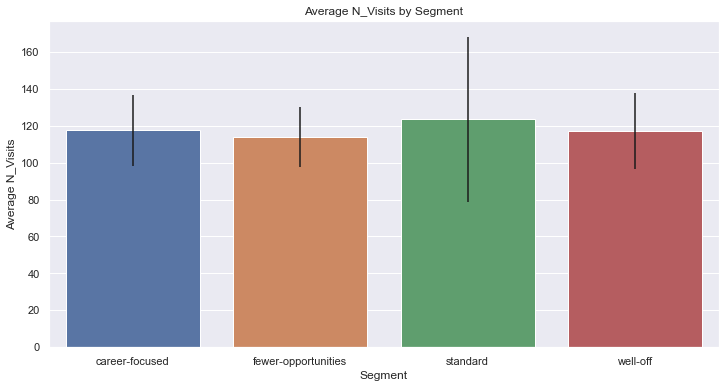

In [17]:
plot_avg_and_std_per_segment(df_customer_stats, 'N_Visits')

The spread amount customers in the standard segment is high implying that these customers are least alike when it comes to how often they visit the store. The other segments are very similar in terms of their store visits. This makes more comparable with respect to our future analysis.

### Purchase Incidence

The second question would like to know is how often do people from different segment buy chocolate candy relative to the store visits.

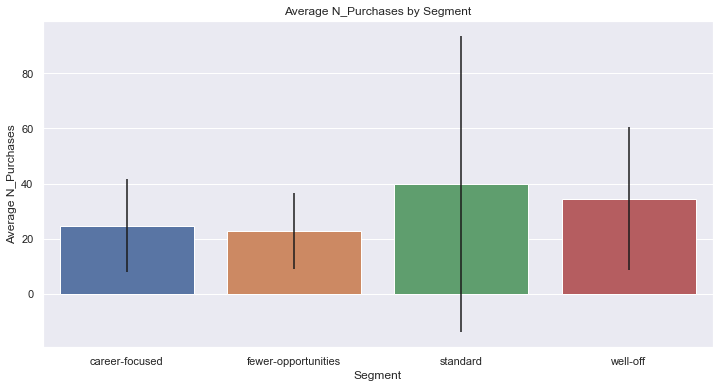

In [18]:
plot_avg_and_std_per_segment(df_customer_stats, 'N_Purchases')

The standard segment buys on average more chocolate candy more often. 
Again, the standard deviation is the highest. 
One explanation could be that a part of the segment buys the product more frequently than other parts.
Although consumers in this segment may have similar income, they might differ in what they spend their money on.

The most homogeneous segment appears to be consumers in the Fewer-Opportunities segment. This is signified by the segment having the lowest standard deviation.



### Purchase Frequency

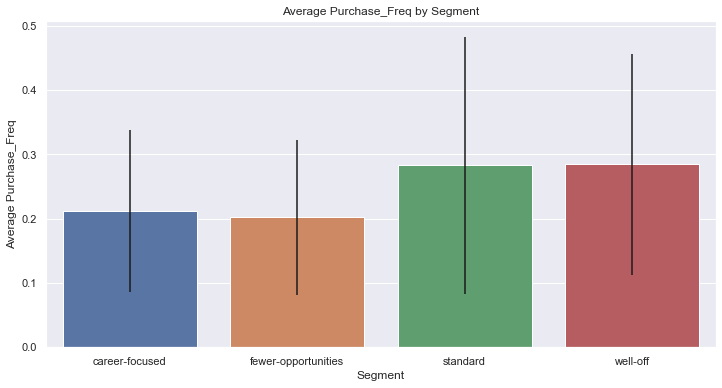

In [19]:
plot_avg_and_std_per_segment(df_customer_stats, 'Purchase_Freq')

### Brand Choice

In [20]:
df_purchase_incidents = df_purchases[df_purchases['Incidence'] == 1]

In [21]:
df_brand_features = pd.get_dummies(df_purchase_incidents['Brand'], prefix='Brand', prefix_sep='_')
df_brand_features.head()

,Brand_1,Brand_2,Brand_3,Brand_4,Brand_5
6,0,1,0,0,0
11,0,0,0,0,1
19,1,0,0,0,0
24,0,0,0,1,0
29,0,1,0,0,0


In [22]:
# Copy segment and ID from the purchases DataFrame
df_brand_features['Segment'] = df_purchase_incidents['Segment']
df_brand_features['ID'] = df_purchase_incidents['ID']
df_brand_features.head()

,Brand_1,Brand_2,Brand_3,Brand_4,Brand_5,Segment,ID
6,0,1,0,0,0,1,200000001
11,0,0,0,0,1,1,200000001
19,1,0,0,0,0,1,200000001
24,0,0,0,1,0,1,200000001
29,0,1,0,0,0,1,200000001


In [23]:
# Compute the average brand choice per customer
df_avg_brand_choice_per_customer = df_brand_features.groupby(['ID']).mean()
df_avg_brand_choice_per_customer.head()

,Brand_1,Brand_2,Brand_3,Brand_4,Brand_5,Segment
ID,,,,,,
200000001,0.111111,0.444444,0.0,0.222222,0.222222,1
200000002,0.000000,0.090909,0.0,0.909091,0.000000,0
200000003,0.000000,0.800000,0.0,0.000000,0.200000,1
200000004,0.000000,0.090909,0.0,0.000000,0.909091,1
200000005,0.000000,0.000000,0.0,0.000000,1.000000,3


In [24]:
# Compute the average brand choice per segment
df_avg_brand_choice_per_segment = df_avg_brand_choice_per_customer.groupby(['Segment']).mean()
df_avg_brand_choice_per_segment.rename(index=segment_labels, inplace=True)
df_avg_brand_choice_per_segment

,Brand_1,Brand_2,Brand_3,Brand_4,Brand_5
Segment,,,,,
well-off,0.041928,0.117422,0.030610,0.613623,0.196417
fewer-opportunities,0.138299,0.679494,0.021034,0.061875,0.099298
career-focused,0.248771,0.402305,0.154976,0.058902,0.135045
standard,0.072871,0.146808,0.039976,0.112395,0.627951


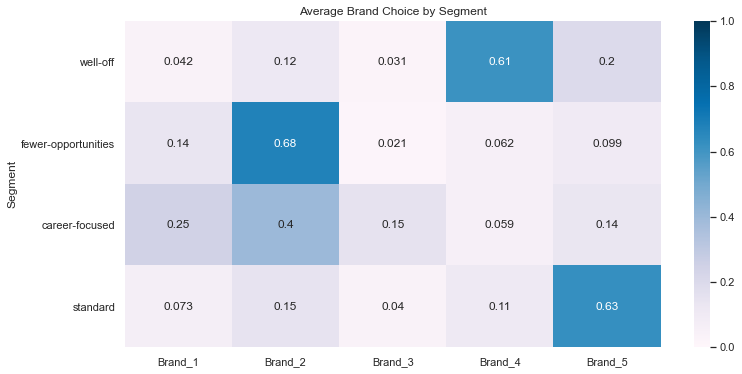

In [25]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.heatmap(df_avg_brand_choice_per_segment, vmin=0, vmax=1, cmap='PuBu', annot=True)
ax.set_title('Average Brand Choice by Segment');

Suppose that the 5 brands are arranged in ascending order of price where Brand 1 is the cheapest one and Brand 2 is the most expensive. We can take this into account when conducting the brand analysis.

- Well-Off consumers tend to prefer the Brand 4 but not the most expensive Brand 5.
- Consumers in Fewer-Opportunities segment have a strong preference for brand 2. Almost 70% of the consumers use this brand of chocolate. Since the Brand 2 is not the cheapest one, the price is not what matters the most for this segment.
- Career-Focused is the most heterogeneous segment. Have a preference for Brand 2 and a weaker preference for Brands 1 and 3. They do not like to buy Brand 4. Their preference is scattered all around. One idea is try to influence them to try out different brands.
- Standard consumers prefer the most expensive brand. It seems that this cluster enjoys this brand. With no additional information, we can speculate that this segment is looking for a luxury status. This alone may be an opportunity to rise of Brand 5.

The mostly bought brands are Brand 4 followed by Brand 5.

How does these brand preferences affect our bottom line?